# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


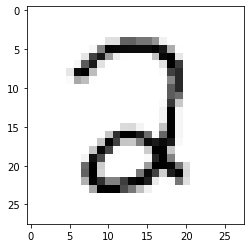

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2059
Training Accuracy: 0.8059, Testing Accuracy: 0.8286



Epoch 10, Loss 0.0506
Training Accuracy: 0.9488, Testing Accuracy: 0.9556



Epoch 20, Loss 0.037
Training Accuracy: 0.9598, Testing Accuracy: 0.9642



Epoch 30, Loss 0.0316
Training Accuracy: 0.9648, Testing Accuracy: 0.9672



Epoch 40, Loss 0.0284
Training Accuracy: 0.9680, Testing Accuracy: 0.9698



Epoch 50, Loss 0.0262
Training Accuracy: 0.9696, Testing Accuracy: 0.9713



Epoch 60, Loss 0.0246
Training Accuracy: 0.9720, Testing Accuracy: 0.9713



Epoch 70, Loss 0.0233
Training Accuracy: 0.9735, Testing Accuracy: 0.9718



Epoch 80, Loss 0.0222
Training Accuracy: 0.9748, Testing Accuracy: 0.9733



Epoch 90, Loss 0.0213
Training Accuracy: 0.9762, Testing Accuracy: 0.9738



Epoch 100, Loss 0.0205
Training Accuracy: 0.9771, Testing Accuracy: 0.9738



Epoch 110, Loss 0.0198
Training Accuracy: 0.9778, Testing Accuracy: 0.9743



Epoch 120, Loss 0.0191
Training Accuracy: 0.9786, Testing Accuracy: 0.9743



Epoch 130, Loss 0.0185
Training Accuracy: 0.9792, Testing Accuracy: 0.9748



Epoch 140, Loss 0.0179
Training Accuracy: 0.9800, Testing Accuracy: 0.9763



Epoch 150, Loss 0.0174
Training Accuracy: 0.9806, Testing Accuracy: 0.9763



Epoch 160, Loss 0.0169
Training Accuracy: 0.9810, Testing Accuracy: 0.9768



Epoch 170, Loss 0.0164
Training Accuracy: 0.9822, Testing Accuracy: 0.9763



Epoch 180, Loss 0.016
Training Accuracy: 0.9825, Testing Accuracy: 0.9778



Epoch 190, Loss 0.0156
Training Accuracy: 0.9829, Testing Accuracy: 0.9783



Epoch 200, Loss 0.0151
Training Accuracy: 0.9831, Testing Accuracy: 0.9783



Epoch 210, Loss 0.0147
Training Accuracy: 0.9836, Testing Accuracy: 0.9783



Epoch 220, Loss 0.0143
Training Accuracy: 0.9840, Testing Accuracy: 0.9798



Epoch 230, Loss 0.014
Training Accuracy: 0.9841, Testing Accuracy: 0.9798



Epoch 240, Loss 0.0136
Training Accuracy: 0.9849, Testing Accuracy: 0.9803



0.03180362879798856

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.2412
Training Accuracy: 0.6911, Testing Accuracy: 0.6900



Epoch 10, Loss 0.1042
Training Accuracy: 0.9053, Testing Accuracy: 0.9168



Epoch 20, Loss 0.0798
Training Accuracy: 0.9268, Testing Accuracy: 0.9425



Epoch 30, Loss 0.0684
Training Accuracy: 0.9366, Testing Accuracy: 0.9491



Epoch 40, Loss 0.0617
Training Accuracy: 0.9418, Testing Accuracy: 0.9521



Epoch 50, Loss 0.0571
Training Accuracy: 0.9448, Testing Accuracy: 0.9546



Epoch 60, Loss 0.0537
Training Accuracy: 0.9479, Testing Accuracy: 0.9597



Epoch 70, Loss 0.0511
Training Accuracy: 0.9498, Testing Accuracy: 0.9587



Epoch 80, Loss 0.049
Training Accuracy: 0.9511, Testing Accuracy: 0.9592



Epoch 90, Loss 0.0473
Training Accuracy: 0.9530, Testing Accuracy: 0.9597



Epoch 100, Loss 0.0459
Training Accuracy: 0.9541, Testing Accuracy: 0.9612



Epoch 110, Loss 0.0447
Training Accuracy: 0.9548, Testing Accuracy: 0.9642



Epoch 120, Loss 0.0436
Training Accuracy: 0.9559, Testing Accuracy: 0.9652



Epoch 130, Loss 0.0427
Training Accuracy: 0.9567, Testing Accuracy: 0.9662



Epoch 140, Loss 0.0419
Training Accuracy: 0.9573, Testing Accuracy: 0.9667



Epoch 150, Loss 0.0411
Training Accuracy: 0.9578, Testing Accuracy: 0.9667



Epoch 160, Loss 0.0405
Training Accuracy: 0.9584, Testing Accuracy: 0.9672



Epoch 170, Loss 0.0399
Training Accuracy: 0.9588, Testing Accuracy: 0.9672



Epoch 180, Loss 0.0393
Training Accuracy: 0.9591, Testing Accuracy: 0.9677



Epoch 190, Loss 0.0388
Training Accuracy: 0.9594, Testing Accuracy: 0.9672



Epoch 200, Loss 0.0383
Training Accuracy: 0.9599, Testing Accuracy: 0.9667



Epoch 210, Loss 0.0379
Training Accuracy: 0.9604, Testing Accuracy: 0.9667



Epoch 220, Loss 0.0375
Training Accuracy: 0.9607, Testing Accuracy: 0.9667



Epoch 230, Loss 0.0371
Training Accuracy: 0.9609, Testing Accuracy: 0.9667



Epoch 240, Loss 0.0367
Training Accuracy: 0.9614, Testing Accuracy: 0.9672



0.07197992954230154

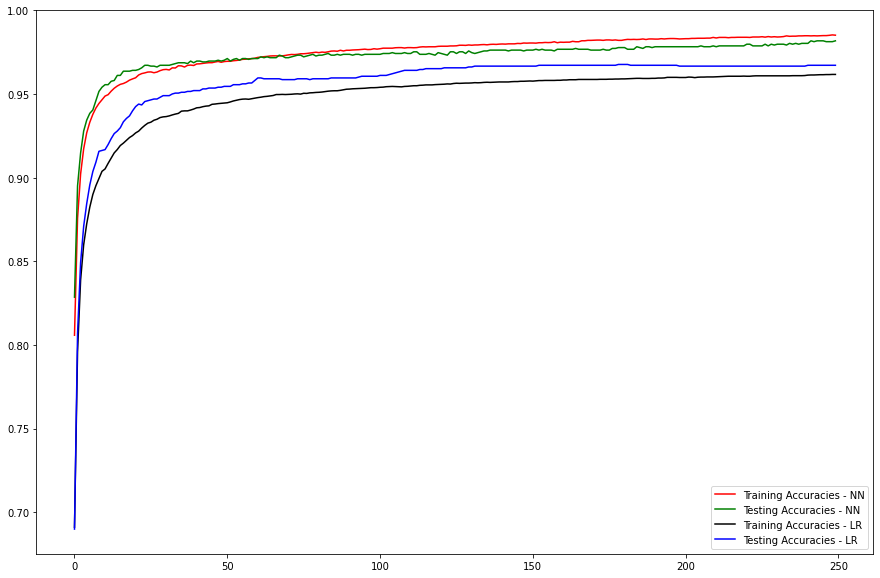

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

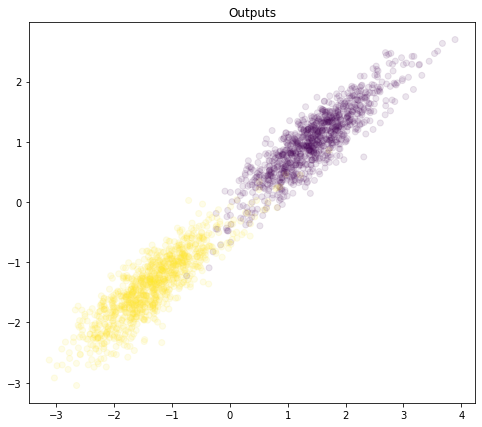

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

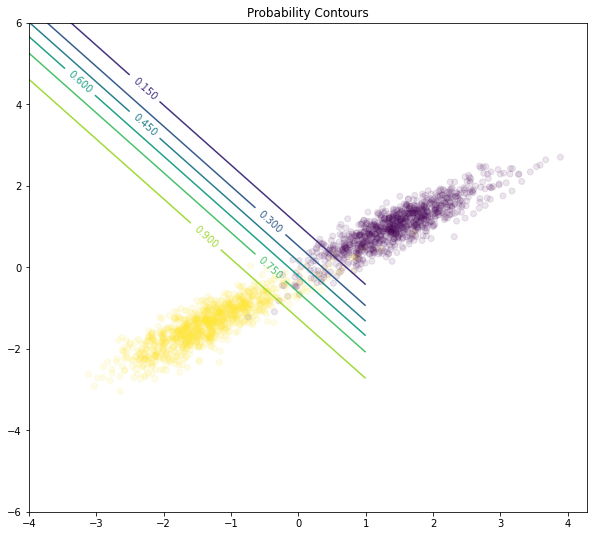

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );